
# <span style="color:rgb(213,80,0)">Silicon Swelling Example</span>

In this example, we illustrate the implementation of Silicon swelling in BattMo.


The Silicon swelling model in BattMo includes

-  Modified solid diffusion equation due to changing particle radius,
-  Volume fraction changes and impact on the effective values of transport parameters, such as diffusion and conductivity in electrolyte and electrode,
-  Addition of an effective convective flux,
-  Modified Butler\-Volmer equation due to the creation of hydrostatic stress as Silicon enters the particles.

We do not include the propagation of mechanical stress.


The modeling equations are taken from the following references

-  Shweta Dhillon et al. “Modelling capacity fade in silicon\-graphite composite electrodes for lithium\-ion batteries”. In: Electrochimica Acta 377 (May 2021).
-  Rajeswari Chandrasekaran and Thomas Fuller. “Analysis of the Lithium\-Ion Insertion Silicon Composite Electrode/Separator/Lithium Foil Cell”. In: ECS Meeting Abstracts MA2011\-02.7 (Aug. 2011).
-  Rajeswari Chandrasekaran et al. “Analysis of Lithium Insertion/Deinsertion in a Silicon Electrode Particle at Room Temperature”. In: Journal of The Electrochemical Society 157.10 (2010).
-  Yang\-Tse Cheng and Mark W Verbrugge. “Evolution of stress within a spherical insertion electrode particle under potentiostatic and galvanostatic operation”. In: Journal of Power Sources 190.2 (2009).
-  Haoliang Li et al. “Effects of stress dependent electrochemical reaction on voltage hysteresis of lithium ion batteries”. In: Applied Mathematics and Mechanics 39.10 (2018).
## Material properties

We load the json structure for the material properties


In [1]:
jsonfilename = fullfile('ParameterData'        , ...
                        'BatteryCellParameters', ...
                        'LithiumIonBatteryCell', ...
                        'lithium_ion_battery_nmc_silicon.json');
jsonstruct_material = parseBattmoJson(jsonfilename);

## Geometry

We load the json structure for the geometrical properties. We consider a P2D model.


In [2]:
jsonfilename = fullfile('Examples', 'JsonDataFiles', 'geometry1d.json');
jsonstruct_geometry = parseBattmoJson(jsonfilename);

## Control

We load the json structure for the geometrical properties


In [3]:
jsonfilename = fullfile('Examples', 'JsonDataFiles', 'cc_discharge_control.json');
jsonstruct_control = parseBattmoJson(jsonfilename);


We merge the json structure inputs an run the simulation


In [4]:
jsonstruct = mergeJsonStructs({jsonstruct_material, ...
                               jsonstruct_geometry, ...
                               jsonstruct_control});

output = runBatteryJson(jsonstruct, 'runSimulation', true);

In [5]:

model  = output.model;
states = output.states;

## Plotting the results

We define some shortcuts


In [6]:
ne      = 'NegativeElectrode';
pe      = 'PositiveElectrode';
co      = 'Coating';
elyte   = 'Electrolyte';
am      = 'ActiveMaterial';
itf     = 'Interface';
sd      = 'SolidDiffusion';


We plot the discharge curve



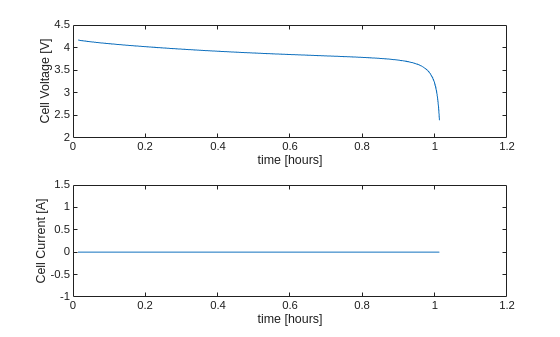

In [7]:
E = cellfun(@(x) x.Control.E, states);
I = cellfun(@(x) x.Control.I, states);
t = cellfun(@(x) x.time, states);

figure()
tiledlayout('flow');

nexttile
plot(t/hour, E)
xlabel('time [hours]')
ylabel('Cell Voltage [V]')

nexttile
plot(t/hour, I)
xlabel('time [hours]')
ylabel('Cell Current [A]')


When a simulation is run, the returned states contain by default only the /primary/ variables, which essentially consist of the concentrations and the electrical potentials. We run the following command to populate the states with all the variables that are known to the model (for example radius, volume fractions...).


In [8]:
for istate = 1 : numel(states)
    states{istate} = model.addVariables(states{istate});
end


We plot the evolution of the radius evolution as a function of time for the spatial locations that correspond to the centers of our discretization mesh cells.



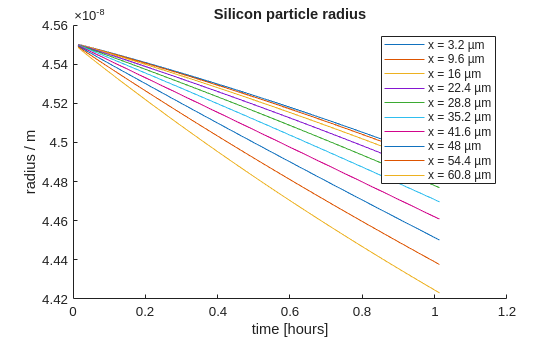

In [9]:
for istate = 1 : numel(states)
    states{istate} = model.evalVarName(states{istate}, {ne, co, am, sd, 'radius'});
end

figure
hold on

nc = model.(ne).grid.cells.num;

for i = 1 : nc

    radius = cellfun(@(state) state.(ne).(co).(am).(sd).radius(i), states);
    lgdtxt = sprintf("x = %g µm", model.(ne).grid.cells.centroids(i, 1)/(micro*meter));
    plot(t/hour, radius, 'displayname', lgdtxt);

end

xlabel('time [hours]')
ylabel('radius / m')
title('Silicon particle radius')
legend show;


We plot the evolution of the porosity in the negative electrove as a function of time for the spatial locations that correspond to the centers of our discretization mesh cells.



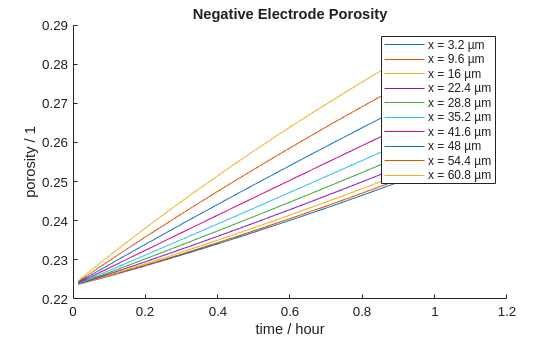

In [10]:
figure
hold on

for i = 1 : nc

    poro = cellfun(@(state) 1 - state.(ne).(co).volumeFraction(i), states);
    lgdtxt = sprintf("x = %g µm", model.(ne).grid.cells.centroids(i, 1)/(micro*meter));
    plot(t/hour, poro, 'displayname', lgdtxt);

end

xlabel('time / hour')
ylabel('porosity / 1')
title('Negative Electrode Porosity')
legend show


We plot the evolutino of the overpotential of the negative electrode as a function of time



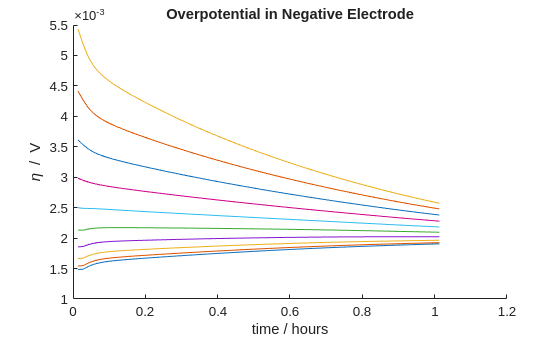

In [11]:
figure
hold on

nc = model.(ne).grid.cells.num;

for i = 1 : nc

    eta = cellfun(@(state) state.(ne).(co).(am).(itf).eta(i), states);
    lgdtxt = sprintf("x = %g µm", model.(ne).grid.cells.centroids(i, 1)/(micro*meter));
    plot(t/hour, eta, 'displayname', lgdtxt);

end

xlabel('time / hours')
ylabel('\eta / V')
title('Overpotential in Negative Electrode')


We plot of the Lithium **total** concentration and the particle average concentration, at each spatial location. By total concentration, we mean the amount of Lithium for a given **total** volume, which includes also the pores. This quantity is relevant because of the change of volume fraction and it is equal to the product of the concentration with the volume fraction. It is also equal to the product of the fill\-in level with the total maximum concentration.



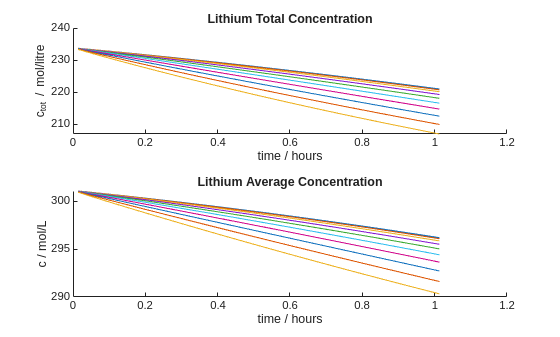

In [12]:
figure
tiledlayout('flow');

nexttile
hold on

% Maximum total concentration
cMaxTot = model.(ne).(co).maximumTotalConcentration;
for i = 1 : nc

    fillInLevel = cellfun(@(state) state.(ne).(co).(am).(sd).x(i), states);
    lgdtxt = sprintf("x = %g µm", model.(ne).grid.cells.centroids(i, 1)/(micro*meter));
    plot(t/hour, fillInLevel.*cMaxTot/(mol/litre), 'displayname', lgdtxt);

end

xlabel('time / hours')
ylabel('c_{tot} / mol/litre')
title('Lithium Total Concentration')

nexttile
hold on

for i = 1 : nc

    cAver = cellfun(@(state) state.(ne).(co).(am).(sd).cAverage(i), states);
    lgdtxt = sprintf("x = %g µm", model.(ne).grid.cells.centroids(i, 1)/(micro*meter));
    plot(t/hour, cAver/(mol/litre), 'displayname', lgdtxt);

end

xlabel('time / hours')
ylabel('c / mol/L')
title('Lithium Average Concentration')


We plot the total Lithium content in the negative electrode and make sure it is linear with a slope that depends on the given discharge rate



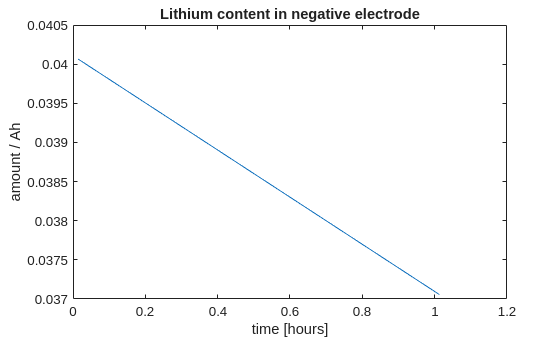

In [13]:
figure

m = [];
vols = model.(ne).(co).grid.cells.volumes;
cMaxTot = model.(ne).(co).maximumTotalConcentration;

for istate = 1 : numel(states)

    state = states{istate};
    x     = state.(ne).(co).(am).(sd).x;

    m(end + 1) = sum(cMaxTot.*x.*vols);

end

F = PhysicalConstants.F;

plot(t/hour, m*F/hour);
xlabel('time [hours]')
ylabel('amount / Ah');
title('Lithium content in negative electrode')